# 小批量随机梯度下降
:label:`sec_minibatch_sgd`

到目前为止，我们在基于梯度的学习方法中遇到了两个极端：:numref:`sec_gd` 使用整个数据集来计算梯度并更新参数，一次一个周期。相反，:numref:`sec_sgd` 每次处理一个训练样本以取得进展。
它们各自都有自己的缺点。
当数据非常相似时，梯度下降在数据效率方面并不特别高。
随机梯度下降在计算效率方面并不特别高，因为 CPU 和 GPU 无法充分利用向量化的优势。
这表明可能有介于两者之间的方法，
事实上，这就是我们在迄今为止讨论的例子中一直在使用的。

## 向量化和缓存

使用小批量的核心在于计算效率。这一点在考虑并行化到多个 GPU 和多个服务器时最容易理解。在这种情况下，我们需要至少将一张图片发送到每个 GPU。如果有 8 个 GPU 每台服务器和 16 台服务器，我们已经达到了最小为 128 的小批量大小。

当涉及到单个 GPU 甚至 CPU 时，情况就有点微妙了。这些设备有多种类型的内存，通常还有多种类型的计算单元以及它们之间不同的带宽限制。
例如，CPU 有少量寄存器，然后是 L1、L2，在某些情况下甚至是 L3 缓存（这是在不同处理器核心之间共享的）。
这些缓存的大小和延迟逐渐增加（同时它们的带宽逐渐减少）。
简而言之，处理器能够执行的操作比主内存接口所能提供的要多得多。

首先，一个 2GHz、16 核且具有 AVX-512 向量化的 CPU 每秒可以处理多达 $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ 字节的数据。GPU 的能力轻松超过这个数字的 100 倍。另一方面，一台中档服务器处理器可能没有超过 100 GB/s 的带宽，即不到所需保持处理器供给的十分之一。更糟糕的是，并非所有的内存访问都是平等的：内存接口通常是 64 位或更宽（例如，在 GPU 上可达 384 位），因此读取单个字节会带来更宽访问的成本。

其次，首次访问会有显著的开销，而顺序访问则相对便宜（这通常称为突发读取）。还有很多其他需要考虑的事情，比如当我们有多个插槽、芯片组和其他结构时的缓存。
有关更深入的讨论，请参阅此 [Wikipedia 文章](https://en.wikipedia.org/wiki/Cache_hierarchy)。

缓解这些限制的方法是使用实际上足够快的 CPU 缓存层次结构来为处理器提供数据。这是深度学习中分批处理的驱动力。为了简单起见，考虑矩阵-矩阵乘法，比如说 $\mathbf{A} = \mathbf{B}\mathbf{C}$。我们有几种计算 $\mathbf{A}$ 的选项。例如，我们可以尝试以下方法：

1. 我们可以计算 $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}$，即通过点积逐元素地进行计算。
1. 我们可以计算 $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}$，即一次计算一列。同样，我们也可以一次计算一行 $\mathbf{A}_{i,:}$。
1. 我们可以直接计算 $\mathbf{A} = \mathbf{B} \mathbf{C}$。
1. 我们可以将 $\mathbf{B}$ 和 $\mathbf{C}$ 分解成更小的块矩阵，并一次计算一个块的 $\mathbf{A}$。

如果我们选择第一个选项，每次我们要计算一个元素 $\mathbf{A}_{ij}$ 时，都需要将一行和一列向量复制到 CPU 中。更糟糕的是，由于矩阵元素是按顺序排列的，因此我们在从内存中读取这两个向量中的一个时，必须访问许多不连续的位置。第二个选项更有利。在这种情况下，我们可以将列向量 $\mathbf{C}_{:,j}$ 保留在 CPU 缓存中，同时继续遍历 $\mathbf{B}$。这将内存带宽需求减半，从而加快访问速度。当然，选项 3 是最理想的。不幸的是，大多数矩阵可能无法完全放入缓存（这正是我们正在讨论的内容）。然而，选项 4 提供了一个实用的替代方案：我们可以将矩阵的块移动到缓存中并在本地进行乘法运算。优化库为我们处理了这一点。让我们看看这些操作在实践中有多高效。

除了计算效率之外，Python 和深度学习框架本身引入的开销也是相当大的。回想一下，每次我们执行一个命令时，Python 解释器都会向 MXNet 引擎发送一个命令，引擎需要将其插入计算图并在调度时处理它。这种开销可能会非常有害。简而言之，强烈建议尽可能使用向量化（和矩阵）。

In [1]:
%matplotlib inline
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

既然我们将在本书的其余部分频繁地进行运行时间基准测试，那么让我们定义一个计时器。

In [2]:
class Timer:  #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

timer = Timer()

逐元素赋值就是分别遍历$\mathbf{B}$和$\mathbf{C}$的所有行和列，将值赋给$\mathbf{A}$。

In [3]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.7845737934112549

一种更快的策略是进行列式分配。

In [4]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.06541275978088379

最后，最有效的方法是将整个操作一次性完成。请注意，当标量乘法和加法被视为单独的操作时（实际上通常是融合的），乘以任何两个矩阵 $\mathbf{B} \in \mathbb{R}^{m \times n}$ 和 $\mathbf{C} \in \mathbb{R}^{n \times p}$ 大约需要 $2mnp$ 次浮点运算。因此，乘以两个 $256 \times 256$ 的矩阵需要 $0.03$ 亿次浮点运算。让我们来看看这些操作的速度分别是多少。

In [5]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

gigaflops = [0.03 / i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.017, column 0.459, full 51.633


## 小批量

:label:`sec_minibatches`

过去，我们理所当然地认为我们会读取*小批量*的数据而不是单个观测值来更新参数。我们现在对此做一个简要的解释。处理单个观测值需要我们执行许多单个矩阵-向量（甚至是向量-向量）乘法，这相当昂贵，并且会给底层深度学习框架带来显著的开销。这既适用于将网络应用于数据时的评估（通常称为推理），也适用于计算梯度以更新参数时的情况。也就是说，每当执行 $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ 时都适用，其中

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

我们可以通过一次应用一小批观测值来提高此操作的*计算*效率。也就是说，我们将单个观测值的梯度 $\mathbf{g}_t$ 替换为一个小批量的梯度

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

让我们看看这对 $\mathbf{g}_t$ 的统计特性有什么影响：由于 $\mathbf{x}_t$ 和小批量 $\mathcal{B}_t$ 中的所有元素都是从训练集中均匀随机抽取的，因此梯度的期望保持不变。另一方面，方差显著降低。由于小批量梯度由 $b \stackrel{\textrm{def}}{=} |\mathcal{B}_t|$ 个独立梯度组成并进行平均，其标准差减少了 $b^{-\frac{1}{2}}$ 倍。这本身是一件好事，因为它意味着更新更可靠地与完整梯度对齐。

直观上这表明选择一个大的小批量 $\mathcal{B}_t$ 是普遍可取的。然而，在某个点之后，与线性增加的计算成本相比，标准差的额外减少变得微不足道。在实践中，我们选择足够大的小批量以提供良好的计算效率，同时仍能适应 GPU 的内存。为了说明节省的效果，让我们看一下一些代码。在代码中，我们执行相同的矩阵-矩阵乘法，但这次将其分解为每次 64 列的“小批量”。

In [6]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {0.03 / timer.times[3]:.3f}')

performance in Gigaflops: block 37.640


正如我们所见，对小批量进行计算本质上与对整个矩阵进行计算一样高效。需要注意的是，在 :numref:`sec_batch_norm` 中，我们使用了一种严重依赖于小批量中差异量的正则化方法。当我们增加后者时，方差会减小，随之而来的由于批量归一化带来的噪声注入的好处也会减少。有关如何重新调整和计算适当项的详细信息，请参阅例如 :citet:`Ioffe.2017`。

## 读取数据集

让我们来看看如何从数据中有效地生成小批量。在下面的例子中，我们使用了 NASA 开发的一个数据集来测试不同飞机 [机翼噪声](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)，以此来比较这些优化算法。为方便起见，我们仅使用前 $1,500$ 个示例。数据经过预处理进行了白化，即我们去除了均值并将每个坐标上的方差重新缩放到 $1$。

In [7]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

## 从零开始实现

回想一下:numref:`sec_linear_scratch`中的小批量随机梯度下降实现。下面，我们提供了一个稍微更通用的实现。为了方便起见，它的调用签名与其他本章后面介绍的优化算法相同。具体来说，我们添加了状态输入`states`，并将超参数放在字典`hyperparams`中。此外，在训练函数中我们将对每个小批量样本的损失进行平均，因此优化算法中的梯度不需要再除以批量大小。

In [8]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

接下来，我们实现一个通用的训练函数，以便于使用本章后面介绍的其他优化算法。它初始化一个线性回归模型，并可以用来通过小批量随机梯度下降和其他后续介绍的算法来训练模型。

In [9]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

让我们看看批量梯度下降的优化过程。这可以通过将小批量大小设置为1500（即所有样本的总数）来实现。因此，模型参数每个周期只更新一次。进展很小。实际上，在6步之后进展就停滞了。

loss: 0.247, 0.020 sec/epoch


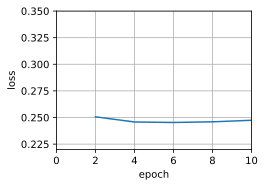

In [10]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

当批量大小等于1时，我们使用随机梯度下降进行优化。为了实现的简便性，我们选择了一个恒定（尽管很小）的学习率。在随机梯度下降中，每当处理一个样本时，模型参数就会更新。在我们的情况下，这意味着每个epoch有1500次更新。可以看到，目标函数的值在一个epoch后下降速度变慢。虽然两种方法都在一个epoch内处理了1500个样本，但在我们的实验中，随机梯度下降比梯度下降耗时更多。这是因为随机梯度下降更频繁地更新参数，并且每次处理单个观测值的效率较低。

loss: 0.245, 0.685 sec/epoch


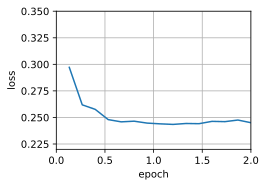

In [11]:
sgd_res = train_sgd(0.005, 1)

最后，当批量大小等于100时，我们使用小批量随机梯度下降进行优化。每个epoch所需的时间比随机梯度下降和批量梯度下降所需的时间都要短。

loss: 0.246, 0.025 sec/epoch


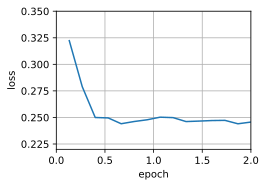

In [12]:
mini1_res = train_sgd(.4, 100)

将批量大小减少到10，每个epoch的时间会增加，因为每个批次的工作负载执行起来效率更低。

loss: 0.246, 0.090 sec/epoch


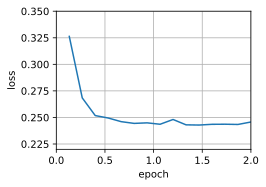

In [13]:
mini2_res = train_sgd(.05, 10)

现在我们可以比较前四个实验的时间与损失。可以看出，尽管随机梯度下降在处理样本数量方面比GD收敛得更快，但由于逐个样本计算梯度的效率不高，它达到相同损失所需的时间比GD更长。小批量随机梯度下降能够在收敛速度和计算效率之间取得平衡。批量大小为10的小批量随机梯度下降比随机梯度下降更有效；批量大小为100的小批量随机梯度下降甚至在运行时间上优于GD。

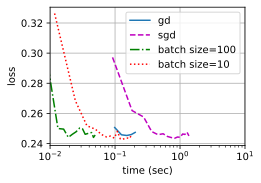

In [14]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

## 简洁实现

在Gluon中，我们可以使用`Trainer`类来调用优化算法。这用于实现一个通用的训练函数。我们将在本章中使用它。

In [15]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

使用Gluon重复上次的实验显示了相同的行为。

loss: 0.243, 0.096 sec/epoch


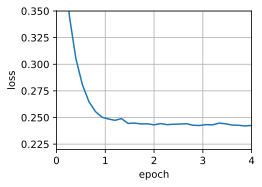

In [16]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 摘要

* 向量化使代码更高效，因为它减少了深度学习框架的开销，并提高了CPU和GPU上的内存局部性和缓存效果。
* 从随机梯度下降中获得的统计效率与一次处理大量数据的计算效率之间存在权衡。
* 小批量随机梯度下降结合了两者的优点：计算效率和统计效率。
* 在小批量随机梯度下降中，我们通过训练数据的随机排列来处理数据批次（即每个观察值在一个周期内仅被处理一次，但顺序是随机的）。
* 建议在训练过程中降低学习率。
* 一般来说，在以时间衡量的情况下，小批量随机梯度下降比随机梯度下降和梯度下降更快地收敛到较小的风险。

## 练习

1. 修改批量大小和学习率，观察目标函数值下降的速度以及每个周期消耗的时间。
1. 阅读MXNet文档并使用`Trainer`类的`set_learning_rate`函数，在每个周期后将小批量随机梯度下降的学习率减少为其先前值的1/10。
1. 将小批量随机梯度下降与实际从训练集中*有放回抽样*的变体进行比较。会发生什么？
1. 一个邪恶的精灵复制了你的数据集却没有告诉你（即每条观测数据出现两次，你的数据集规模扩大了一倍，但是没人告诉你）。随机梯度下降、小批量随机梯度下降以及梯度下降的行为会如何变化？

[讨论](https://discuss.d2l.ai/t/1068)